# Application of Transformer MCMC to a simple case

In this notebook we will consider the integral
$$
I = \int_{-\infty}^{\infty} dx \, \frac{e^{-x^2}}{\sqrt{\pi}} \, \cos(k \, x) 
$$
In this example we will consider $k=20$.

To compute such integral we will sample from the normalized distribution
$$
\rho = \frac{e^{-x^2}}{\sqrt{\pi}}
$$
and we will estimate
$$
g = \cos(k \, x)
$$

As first thing, let us visualize how the integrand looks like.

In [7]:
 var('x', 'q')

(x, q)

In [8]:
k = 20
rho = exp(-x^2) / sqrt(pi)
g = cos(k*x)

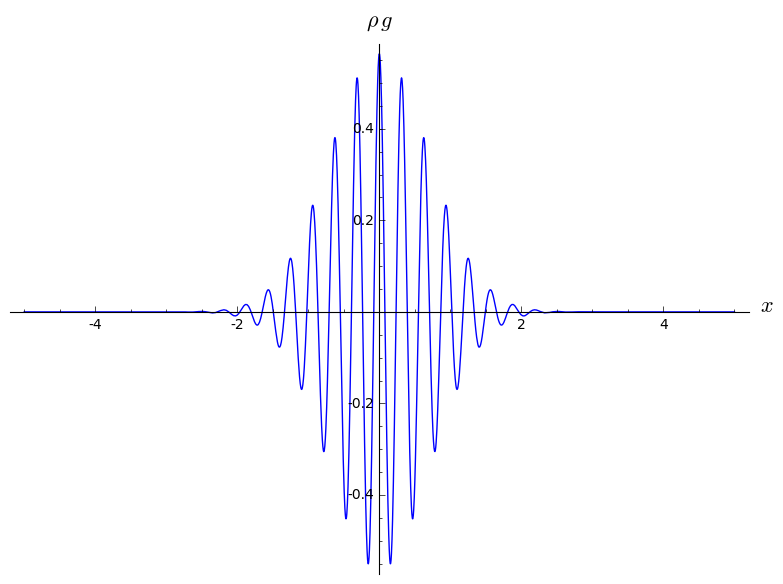

In [9]:
plot(rho*g, (x, -5, 5), axes_labels=[r'$x$', r'$\rho \, g$'])

The integrand fluctuates greatly, due to the $\cos$ function.

As first thing we want to estimate the MCMC variance of this integral. This can be analytically computed as
$$
\text{MCMC variance} = \int_{-\infty}^{\infty} dx \, \rho(x) \, g^2(x) - \left( \int_{-\infty}^{\infty} dx \, \rho(x) \, g(x) \right)^2
$$

Numerically:

In [10]:
def compute_integral(a, b, rho, g):
    return integrate(rho * g, x, a, b)

In [11]:
def compute_mcmc_variance(a, b, rho, g):
    return (integrate(rho * g^2, x, a, b) - (compute_integral(a, b, rho, g))^2)

In [12]:
def print_mcmc_info(a, b, rho, g):
    print('MCMC Integral: {}'.format(float(compute_integral(a, b, rho, g))))
    print('MCMC Variance: {}'.format(float(compute_mcmc_variance(a, b, rho, g))))

In [13]:
print_mcmc_info(-oo, oo, rho, g)

MCMC Integral: 3.72007597602e-44
MCMC Variance: 0.5


### First Transformation

Now we want to use the Transformer MCMC technique. We will restrict ourselves to a simple transformation: a constant shift. In formula:
$$
t(x) = x + q \frac{\pi}{k}
$$
$q$ is a parameter that can be tuned to minimize the variance of the MCMC integral. Our intuition suggests that a value $q=1$ is probably optimal, as it will make the sum of the two values average over the oscillations due to the $\cos$ function, but we will not trust our intuition.

Our goal is now to inspect how the Transformer MCMC variance varies for different values of $q$. Notice that for simmetry reasons we can restrict our search in the domain $q > 0$.

In [14]:
t = x + q*pi/k
forget()
assume(q > 0)
twin_sampling_variance_gr0 = compute_mcmc_variance(-oo, oo, rho, (g + (rho(t) / rho) * g(t)) / 2)

/opt/sage/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2882: DeprecationWarning: Substitution using function-call syntax and unnamed arguments is deprecated and will be removed from a future release of Sage; you can use named arguments instead, like EXPR(x=..., y=...)
See http://trac.sagemath.org/5930 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


Here is the graph that we were looking for:

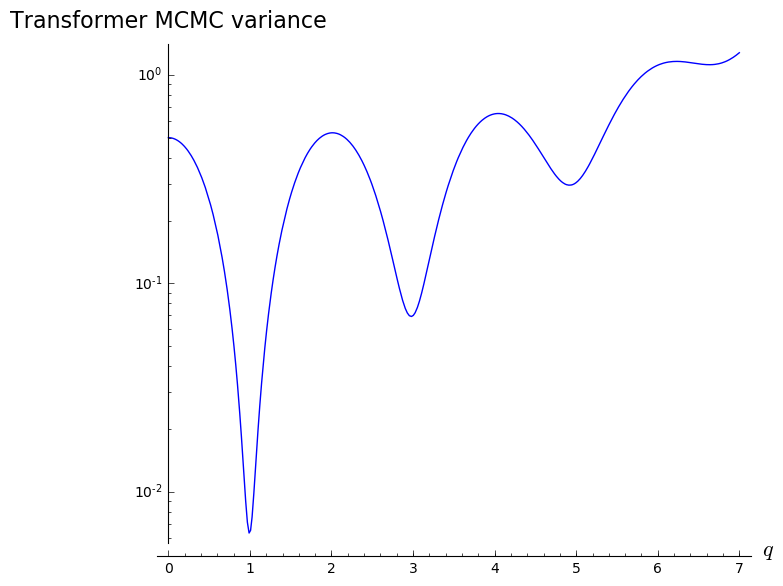

In [16]:
plot(twin_sampling_variance_gr0, (q, 0, 7), scale='semilogy', 
     axes_labels=[r'$q$', 'Transformer MCMC variance'])

This confirms our intuition: $q=1$ is indeed the optimal value.

Let us make things official, by re-computing the MCMC integral (to verify that we didn't do mistakes) and variance:

In [17]:
t1 = x + pi/k
print_mcmc_info(-oo, oo, rho, (g 
                               + (rho(t1) / rho) * t1.derivative(x) * g(t1)) / 2)

MCMC Integral: 3.72007597602e-44
MCMC Variance: 0.00632323926763


We have reduced the variance from $0.5$ to $0.0063$, i.e. we have gained a factor 100. Notice that the integral value is the same, which demonstrates that we did not commit any mistake.

### Second Transformation

Now we want to push further, and try to introduce a second transformation to average over. Again, we will restrict ourselves to a constant shift. We will furthermore keep the first transformation fixed. In other words, we will have a first shift transformation with $q=1$, and a second transformation with $q$ as parameter.

In [18]:
t = x + q*pi/k

forget()
assume(q < 0)
twin_sampling_2_variance_neg = compute_mcmc_variance(-oo, oo, rho, 
                                                     (g + (rho(t1) / rho) * g(t1) + rho(t) / rho * g(t)) / 3)
forget()
assume(q > 0)
assume(q < 1)
twin_sampling_2_variance_0_1 = compute_mcmc_variance(-oo, oo, rho, 
                                                     (g + (rho(t1) / rho) * g(t1) + rho(t) / rho * g(t)) / 3)
                                                     
forget()
assume(q > 1)
twin_sampling_2_variance_gr1 = compute_mcmc_variance(-oo, oo, rho, 
                                                     (g + (rho(t1) / rho) * g(t1) + rho(t) / rho * g(t)) / 3)

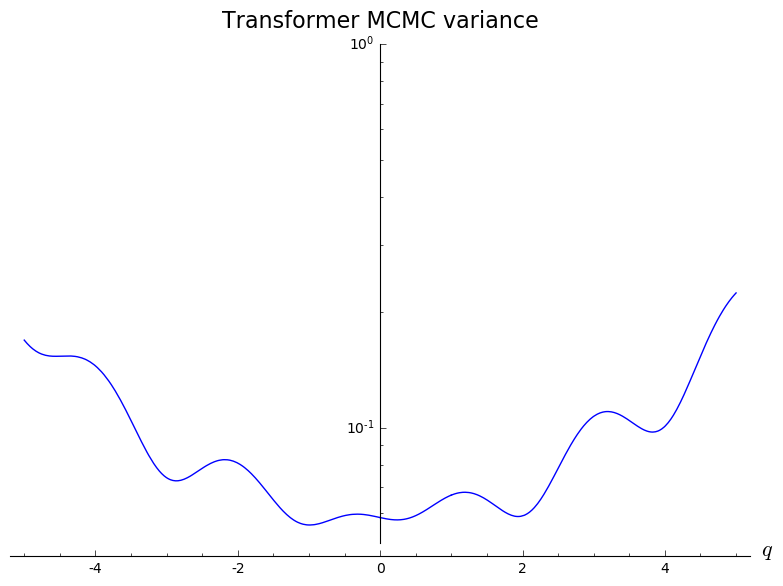

In [19]:
graph = Graphics()
graph += plot(twin_sampling_2_variance_neg, (q, -5, 0), 
              scale='semilogy', axes_labels=[r'$q$', 'Transformer MCMC variance'])
graph += plot(twin_sampling_2_variance_0_1, (q, 0, 1), 
              scale='semilogy', axes_labels=[r'$q$', 'Transformer MCMC variance'])
graph += plot(twin_sampling_2_variance_gr1, (q, 1, 5), 
              scale='semilogy', axes_labels=[r'$q$', 'Transformer MCMC variance'])
graph.show()

This result is very interesting. By introducing a second transformation we have worsen the MCMC variance. In any case, the optimal $q$ for the second transformation is $q=-1$. Let us compute again integral value and variance with this optimal parameter:

In [20]:
t2 = x - pi/k
print_mcmc_info(-oo, oo, rho, (g 
                               + rho(t1) / rho * t1.derivative(x) * g(t1)
                               + rho(t2) / rho * t2.derivative(x) * g(t2)) / 3)

MCMC Integral: 3.72007597602e-44
MCMC Variance: 0.0558261912789


As the number above shows, we have lost a factor 10. This seems to be counterintuitive. However, there is a reason, but it will be more clear if we continue and add a third transformation.

Let us then proceed and introduce a third constant shift transformation.

### Third Transformation

In [21]:
t = x + q*pi/k

forget()
assume(q < -1)
twin_sampling_3_variance_sm1 = compute_mcmc_variance(-oo, oo, rho, 
                                                     (g + (rho(t1) / rho) * g(t1) 
                                                      + rho(t2) / rho * g(t2)
                                                      + rho(t) / rho * g(t)) / 4)
forget()
assume(q > -1)
assume(q < 0)
twin_sampling_3_variance_m10 = compute_mcmc_variance(-oo, oo, rho, 
                                                     (g + (rho(t1) / rho) * g(t1) 
                                                      + rho(t2) / rho * g(t2)
                                                      + rho(t) / rho * g(t)) / 4)
                                                     
forget()
assume(q > 0)
assume(q < 1)
twin_sampling_3_variance_0_1 = compute_mcmc_variance(-oo, oo, rho, 
                                                     (g + (rho(t1) / rho) * g(t1) 
                                                      + rho(t2) / rho * g(t2)
                                                      + rho(t) / rho * g(t)) / 4)

forget()
assume(q > 1)
twin_sampling_3_variance_gr1 = compute_mcmc_variance(-oo, oo, rho, 
                                                     (g + (rho(t1) / rho) * g(t1) 
                                                      + rho(t2) / rho * g(t2)
                                                      + rho(t) / rho * g(t)) / 4)

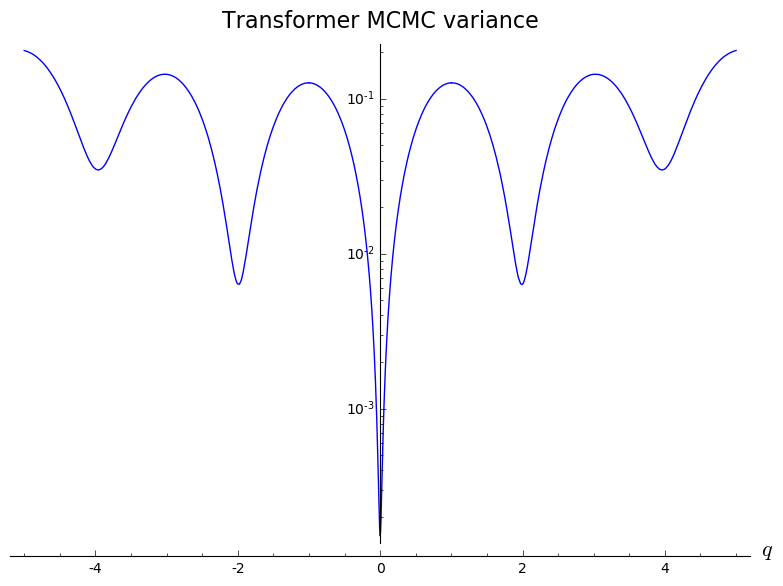

In [23]:
graph = Graphics()
graph += plot(twin_sampling_3_variance_sm1, (q, -5, -1), 
              scale='semilogy', axes_labels=[r'$q$', 'Transformer MCMC variance'])
graph += plot(twin_sampling_3_variance_m10, (q, -1, 0), 
              scale='semilogy', axes_labels=[r'$q$', 'Transformer MCMC variance'])
graph += plot(twin_sampling_3_variance_0_1, (q, 0, 1), 
              scale='semilogy', axes_labels=[r'$q$', 'Transformer MCMC variance'])
graph += plot(twin_sampling_3_variance_gr1, (q, 1, 5), 
              scale='semilogy', axes_labels=[r'$q$', 'Transformer MCMC variance'])
graph.show()

The result can be surprising for many. In this case the optimal $q$ value is $0$, i.e. no shift.

In [44]:
t3 = x
print_mcmc_info(-oo, oo, rho, (g 
                               + rho(t1) / rho * t1.derivative(x) * g(t1)
                               + rho(t2) / rho * t2.derivative(x) * g(t2)
                               + rho(t3) / rho * t3.derivative(x) * g(t3)) / 4)

MCMC Integral: 3.72007597602e-44
MCMC Variance: 0.000152232594393


As the number above shows, we have gained a factor $~50$ on the best case so far (the one with only one transformation).

This means that rather than applying a third transformation, which is nothing but an identity, we can assign a weight 2 to the original estimator $g$, and keep the transformation 1 and 2 only. Let us demonstrate it in practice:

In [45]:
print_mcmc_info(-oo, oo, rho, (2*g 
                               + rho(t1) / rho * t1.derivative(x) * g(t1)
                               + rho(t2) / rho * t2.derivative(x) * g(t2)) / 4)

MCMC Integral: 3.72007597602e-44
MCMC Variance: 0.000152232594393


This is most likely the reason why we have deteriorated the MCMC variance when we introduced the second transformation: we have put too much weight on the estimators with values opposite to the original estimator. By introducing the third transformed estimator, we had a chance to re-balance it: two weights on the original estimator sign, two on the opposite sign.

# Conclusion

We have found that, when using the Transformer MCMC, it is beneficial to assign the weights to the original and trasformed estimators. This needs further investigation.